# Phase II: Data Curation, Exploratory Analysis and Plotting (5\%)

### Team Members:
- Colin Hui
- Derek Aslan
- Aydan Ali
- Conor Cummings


## Part 1: 
(1%) Expresses the central motivation of the project and explains the (at least) two key questions to be explored. Gives a summary of the data processing pipeline so a technical expert can easily follow along.

## Problem Motivation

Global economic development remains uneven, especially in today's world where countries  are experiencing different levels of population wellbeing despite similar geopolitical circumstances. Understanding the relationships between economic indicators, political factors, and policy decisions is important for identifying pathways to improved quality of life. This analysis would focus on how these indicators and factors influence population wellbeing across different world regions/countries, overall providing insights that could inform evidence-based policy decisions for sustainable development.
The key questions are as follows:

1. How do the economic factors of a country impact its population's wellbeing?
2. How do the political factors of a country impact its economy?

## Summary of the Data Processing Pipeline

1. Pull data from the World Bank API to get the raw data
2. Clean the data to prepare the data frame for visualization and analysis
3. Visualize using plotting libraries, such as Seaborn, Plotly, and Matplotlib

To process the data, we will first acquire the data from the World Bank developer API. THe data will be sourced from two query systems: the indicator query and the country data query systems. The data will then be processed into a pair of tables indexed by the unique 2-letter identifier each country is assigned by the World Bank. These tables will be joined then converted into a .csv file for storage.

The data will be used in multiple different ways. Primarily, we will perform statistical analyses and construct graphic visualizations of the data. We will also use the data to train machine learning models to help predict answers for our two key questions.

## Part 2: 
(2\%) Obtains, cleans, and merges all data sources involved in the project.

In [3]:
import pandas as pd
import requests
import json



indicators = {
    'SP.POP.TOTL': 'Population, total',
    'NY.GNP.PCAP.CD': 'GDP Per Captia',
    'SI.POV.DDAY': 'Poverty headcount ratio at $3.00 a day (2021 PPP)',
    'SI.POV.GINI': 'Gini index',
    'MS.MIL.XPND.GD.ZS': 'Military expenditure (% of GDP)',
    'VA.EST': 'Voice and Accountability: Estimate'
}

params = {
    'format': 'json',
    'per_page': '300', # This makes sure all countries are returned
    'date': '2023' #Query just one year
}


def get_api_url(indicator, params):
    """
    Constructs a URL for the API call, to query a given indicator and with a given set of parameters.

    Args:
        indicator: the indicator ID string
        params: a dictionary containing the API call parameters

    Returns:
        A URL to send an HTTP request to to get the API data
    """
    baseurl = 'https://api.worldbank.org/v2/country/all/indicator/'

    url = baseurl + indicator + '?'
    for param in params.keys():
        url = url + param + '=' + params[param] + '&'
    return url

def get_country_data():
    """
    Gets country region and income level as a dataframe indexed by country id.

    Args: 
        None

    Returns:
        DataFrame with country id as index and region/incomeLevel as columns

    """
    response = requests.get("https://api.worldbank.org/v2/country?format=json&per_page=296")
    country_data = json.loads(response.text)[1]

    country_dct = {}

    for dict in country_data:
        if dict["region"]["value"] != "Aggregates":
            country_dct[dict["iso2Code"]] = {
                "region": dict["region"]["value"],
                "incomeLevel": dict["incomeLevel"]["value"],
            }
    df = pd.DataFrame.from_dict(country_dct, orient = "index")
                
    #print(df)

    return df

def get_indicator_data(indicators):
    """
    Gets and cleans the indicator data into a dataframe indexed by country id.

    Args:
        indicator: the indicator ID string

    Returns:
        Dataframe with country id as index and the indicators as columns

    """


    indicator_data = {}
    #Loop through each indicator and make an API call for each. Unfortunately, each API call can only return data for 1 indicator.
    for indicator in indicators.keys():
        indicator_data[indicator] = json.loads(requests.get(get_api_url(indicator, params)).text)

    indicator_series_list = []

    for indicator in indicator_data.keys():
        indicator_dict = {}
        for country in indicator_data[indicator][1]:
            country_id = country['country']['id']
            if len(country_id) == 2 and country_id.isalpha() and country_id.isupper():
                indicator_dict[country_id] = country['value']

        indicator_series = pd.Series(indicator_dict)
        indicator_series.name = indicator
        indicator_series_list.append(indicator_series)
    output = pd.DataFrame(indicator_series_list).transpose()
    #print(output)
    return output


def merge_data(country_df, indicator_df):
    """
    Merges country dataframe with indicator dataframe based on the country id index.
    
    Args:
        country_df: DataFrame with region/income data
        indicator_df: DataFrame with indicator data
        
    Returns:
        finalized merged dataframe containing country and indicator data
    """
    merge_df = pd.merge(indicator_df, country_df, left_index = True,
                         right_index = True, how = "right")
    return merge_df



if __name__ == "__main__":
    country_df = get_country_data()
    indicator_df = get_indicator_data(indicators)
    merged_data = merge_data(country_df, indicator_df)
    print(merged_data)

    merged_data.to_csv('world_bank_data_2023.csv')

    SP.POP.TOTL  NY.GNP.PCAP.CD  SI.POV.DDAY  SI.POV.GINI  MS.MIL.XPND.GD.ZS  \
AW     107359.0         30120.0          NaN          NaN                NaN   
AF   41454761.0           370.0          NaN          NaN                NaN   
AO   36749906.0          2130.0          NaN          NaN           1.332529   
AL    2745972.0          7680.0          NaN          NaN           1.743992   
AD      80856.0         47920.0          NaN          NaN                NaN   
..          ...             ...          ...          ...                ...   
XK    1682668.0          6290.0          NaN          NaN           1.254180   
YE   39390799.0             NaN          NaN          NaN                NaN   
ZA   63212384.0          6480.0          NaN          NaN           0.733137   
ZM   20723965.0          1290.0          NaN          NaN           1.303002   
ZW   16340822.0          2060.0          NaN          NaN           0.248808   

      VA.EST                           

## Part 3:
(2\%) Builds at least two visualizations (graphs/plots) from the data which help to understand or answer the questions of interest. These visualizations will be graded based on how much information they can effectively communicate to readers. Please make sure your visualization are sufficiently distinct from each other.

In [4]:
import pandas as pd
import plotly.express as px
import numpy as np

# put the csv back into a DataFrame
df = pd.read_csv('world_bank_data_2023.csv', index_col=0)

# Clean the data and remove rows with missing values for variables we're using
df_clean = df.dropna(subset=['NY.GNP.PCAP.CD', 'VA.EST', 'SP.POP.TOTL'])

# Create the scatter plot, using GDP per Capita as X, Voice and Accountability Scores as Y, color-code each country's point by region,
# use bubble size to depict the population size of the country, and create hover data for each point/country
fig = px.scatter(
    df_clean,
    x='NY.GNP.PCAP.CD',
    y='VA.EST',
    size='SP.POP.TOTL',
    color='region',
    hover_name=df_clean.index,
    hover_data={
        'NY.GNP.PCAP.CD': ':,.0f',
        'VA.EST': ':.3f',
        'SP.POP.TOTL': ':,.0f',
        'incomeLevel': True,
        'region': False
    },
    labels={
        'NY.GNP.PCAP.CD': 'GDP per Capita (USD)',
        'VA.EST': 'Voice and Accountability Score',
        'SP.POP.TOTL': 'Population',
        'region': 'Region',
        'incomeLevel': 'Income Level'
    },
    title='Economic Prosperity vs. Political Voice in 2023',
    size_max=60,
    opacity=0.7
)


# Fixed layout so it looks better and switch to log scale for x-axis due to GDP values on differing levels of scale
fig.update_layout(
    width=1200,
    height=700,
    font=dict(size=12),
    legend=dict(
        title=dict(text='Region', font=dict(size=14)),
        orientation='v',
        yanchor='top',
        y=1,
        xanchor='left',
        x=1.02
    ),
    hovermode='closest')
fig.update_xaxes(type='log', title='GDP per Capita (USD, log scale)')

fig.show()

This graph shows the relationship between GDP per Capita and the Voice & Accountability Score. We can see the relationship between countries' income per person and their people's perception of their ability to participate in government elections, have free media, and various freedoms of expression. We can see a strong positive correlation. This tells us that as GDP per capita increases, so does people's ability perception of freedom.

In [8]:
 # Dropping NaNs to ensure graphability
df_clean = df.dropna(subset=['VA.EST', 'MS.MIL.XPND.GD.ZS', 'NY.GNP.PCAP.CD'])

 # Creating plots and setting features
fig_VAM = px.scatter(
    df_clean,
    x='MS.MIL.XPND.GD.ZS',
    log_x=True,
    y='VA.EST',
    color='region',
    size='NY.GNP.PCAP.CD',
    hover_name=df_clean.index,
    hover_data={
        'MS.MIL.XPND.GD.ZS': ':.2f',
        'VA.EST': ':.2f',
        'NY.GNP.PCAP.CD': ':,.0f',
        'incomeLevel': True,
        'region': False
    },
    labels={
        'MS.MIL.XPND.GD.ZS': 'Military Expenditure (% of GDP)',
        'VA.EST': 'Voice & Accountability Score',
        'NY.GNP.PCAP.CD': 'GDP per Capita'
    },
    title='Voice & Accountability vs Military Spending (sized by GDP per Capita)',
    color_discrete_sequence=px.colors.qualitative.Prism,
)

 # Formatting
fig_VAM.update_layout(
    height=600,
    plot_bgcolor='white',
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='lightgray'),
    yaxis=dict(showgrid=True, gridwidth=1, gridcolor='lightgray')
)

fig_VAM.show()

This graph shwos us the Military Expenditure compared to the Voice & Accountability Score. It gives us a look into the correlation between countries with stricter and more centralized control of governance spend and how much their military spend is. The distribution is pretty similar, but it is interesting to note that higher income countries tend to have higher VA scores, and most of those countries predominantly in the Europe and Central Asian region. There are a few outliers with military spending, the largest being Ukraine.

In [1]:
import pandas as pd
import requests
import json


In [2]:
# put the csv back into a DataFrame
df = pd.read_csv('world_bank_data_2023.csv', index_col=0)

# Clean the data and remove rows with missing values for variables we're using
df_clean = df.dropna(subset=['NY.GNP.PCAP.CD', 'VA.EST', 'SP.POP.TOTL', 'MS.MIL.XPND.GD.ZS', 'region'])
df_clean

,SP.POP.TOTL,NY.GNP.PCAP.CD,SI.POV.DDAY,SI.POV.GINI,MS.MIL.XPND.GD.ZS,VA.EST,region,incomeLevel
AO,36749906.0,2130.0,NaN,NaN,1.332529,-0.737252,Sub-Saharan Africa,Lower middle income
AL,2745972.0,7680.0,NaN,NaN,1.743992,0.168997,Europe & Central Asia,Upper middle income
AR,45538401.0,12890.0,1.2,42.4,0.472747,0.533922,Latin America & Caribbean,Upper middle income
AM,2964300.0,6840.0,1.9,27.2,5.450925,0.076708,Europe & Central Asia,Upper middle income
AU,26652777.0,63160.0,NaN,NaN,1.922199,1.506602,East Asia & Pacific,High income
...,...,...,...,...,...,...,...,...
US,336806231.0,80710.0,1.2,41.8,3.361836,0.877519,North America,High income
XK,1682668.0,6290.0,NaN,NaN,1.254180,-0.088809,Europe & Central Asia,Upper middle income
ZA,63212384.0,6480.0,NaN,NaN,0.733137,0.744892,Sub-Saharan Africa,Upper middle income
ZM,20723965.0,1290.0,NaN,NaN,1.303002,-0.047946,Sub-Saharan Africa,Lower middle income


In [3]:
def kNN(k, train_x, train_y, x_real, distance_function):
    """
    Performs a k-nearest-neighbors classification on a data point x_real.
    Args:
        k: the number of neighbors
        train_x: a dataframe containing a set of reference data entries
        train_y: a dataframe containing the corresponding set of classifications for train_x
        x_real: a dataframe containing the target to classify
        distance_function (input1, input2) : a function that returns the distance between two data points.
            Args:
                input1: a dictionary of values corresponding to a data point
                input2: another such dictionary
            Returns:
                distance: a number representing the distance between the data points.

    Returns:
        y_prediction: a predicted classification for x_real
    """

    train_x_dict = train_x.to_dict('index')
    train_y_dict = train_y.to_dict()    
    distances = {}
    for key in train_x_dict.keys():
        distances[key] = distance_function(train_x_dict[key], x_real)
    sorted_distances = sorted(distances.items(), key=lambda item: item[1])
    neighbors = []
    for i in range(k):
        neighbors.append(train_y_dict[sorted_distances[i][0]])
    return max(set(neighbors), key=neighbors.count)

In [4]:
def kNN_Simple(k, x_real):
    """
    A simplified version of kNN which automatically selects the training data and distance function.
    Args:
        k: the number of neighbors
        x_real: a dataframe containing the target to classify

    Returns:
        y_prediction: a predicted classification for x_real
    """
    return kNN(
        k,
        df_clean.loc[:, ['SP.POP.TOTL', 'NY.GNP.PCAP.CD', 'MS.MIL.XPND.GD.ZS', 'VA.EST']],
        df_clean.loc[:, 'region'],
        x_real,
        dist_function
    )

In [5]:
def dist_function(input1, input2):
    """
    Computes the distance between two data points for a kNN classifier.
    Args:
        input1: a dictionary of values corresponding to a data point
        input2: another such dictionary
    Returns:
        distance: a double representing the distance between the data points.
    """
    distDict = {
        'SP.POP.TOTL': (input1['SP.POP.TOTL'] - input2['SP.POP.TOTL']) / df_clean.std(numeric_only = True)['SP.POP.TOTL'],
        'NY.GNP.PCAP.CD': (input1['NY.GNP.PCAP.CD'] - input2['NY.GNP.PCAP.CD']) / df_clean.std(numeric_only = True)['NY.GNP.PCAP.CD'],
        'MS.MIL.XPND.GD.ZS': (input1['MS.MIL.XPND.GD.ZS'] - input2['MS.MIL.XPND.GD.ZS']) / df_clean.std(numeric_only = True)['MS.MIL.XPND.GD.ZS'],
        'VA.EST': (input1['VA.EST'] - input2['VA.EST']) / df_clean.std(numeric_only = True)['VA.EST'],
    }

    return (distDict['SP.POP.TOTL']**2 + distDict['NY.GNP.PCAP.CD']**2 + distDict['MS.MIL.XPND.GD.ZS']**2 + distDict['VA.EST']**2) ** 0.5

In [6]:
kNN(5, df_clean.loc[:, ['SP.POP.TOTL', 'NY.GNP.PCAP.CD', 'MS.MIL.XPND.GD.ZS', 'VA.EST']], df_clean.loc[:, 'region'], df_clean.loc['AL', ['SP.POP.TOTL', 'NY.GNP.PCAP.CD', 'MS.MIL.XPND.GD.ZS', 'VA.EST']], dist_function)

'Europe & Central Asia'

In [7]:
kNN_Simple(6, df_clean.loc['AL', ['SP.POP.TOTL', 'NY.GNP.PCAP.CD', 'MS.MIL.XPND.GD.ZS', 'VA.EST']])

'Europe & Central Asia'

## Colin's Stuff

Training Set:
  R²: 0.44143318273984544
  MSE: 274270321.9386778
  RMSE: 16561.108717071987

Test Set:
  R²: 0.4725578724899159
  MSE: 251973092.1269616
  RMSE: 15873.66032542468


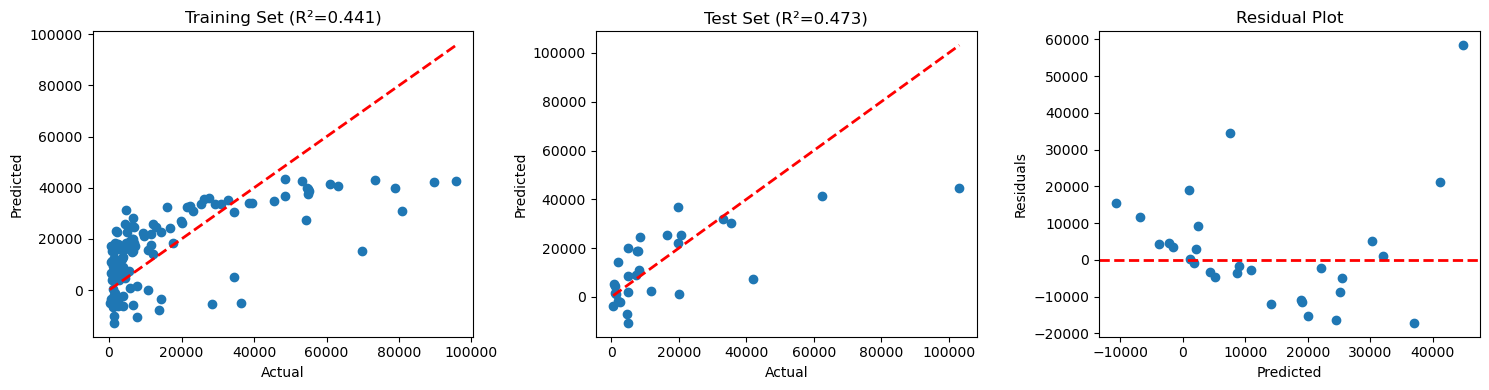

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('world_bank_data_2023.csv', index_col=0)
df_clean = df.dropna(subset=['NY.GNP.PCAP.CD', 'VA.EST', 'MS.MIL.XPND.GD.ZS'])

# Prepare data
X = df_clean[['VA.EST', 'MS.MIL.XPND.GD.ZS']].values
y = df_clean['NY.GNP.PCAP.CD'].values
n = X.shape[0]

# Add bias column
X_b = np.c_[np.ones(n), X]

# Train/test split (80/20)
np.random.seed(42)
indices = np.random.permutation(n)
n_train = int(0.8 * n)
train_idx = indices[:n_train]
test_idx = indices[n_train:]

X_train = X_b[train_idx]
X_test = X_b[test_idx]
y_train = y[train_idx]
y_test = y[test_idx]

# Fit using Normal Equation: theta = (X^T X)^-1 X^T y
theta = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train

# Predictions
y_pred_train = X_train @ theta
y_pred_test = X_test @ theta

# Calculate metrics
def calc_metrics(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return mse, rmse, r2

train_mse, train_rmse, train_r2 = calc_metrics(y_train, y_pred_train)
test_mse, test_rmse, test_r2 = calc_metrics(y_test, y_pred_test)

print("Training Set:")
print(f"  R²: {train_r2}")
print(f"  MSE: {train_mse}")
print(f"  RMSE: {train_rmse}")

print("\nTest Set:")
print(f"  R²: {test_r2}")
print(f"  MSE: {test_mse}")
print(f"  RMSE: {test_rmse}")

# Visualizations
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Training predictions
axes[0].scatter(y_train, y_pred_train)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')
axes[0].set_title(f'Training Set (R²={train_r2:.3f})')

# Plot 2: Test predictions
axes[1].scatter(y_test, y_pred_test)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')
axes[1].set_title(f'Test Set (R²={test_r2:.3f})')

# Plot 3: Residuals
residuals = y_test - y_pred_test
axes[2].scatter(y_pred_test, residuals)
axes[2].axhline(y=0, color='r', linestyle='--', lw=2)
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Residuals')
axes[2].set_title('Residual Plot')

plt.tight_layout()
plt.show()